<a href="https://colab.research.google.com/github/anitamezzetti/financial_big_data/blob/main/AnitaVersion_FinBigData_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
student1 = "Anita Mezzetti"
student2 = "Hien Lê"

Complementary stuff:
* Drive Folder to save data, notebooks and models

Note: project has been linked to [Github](https://github.com/anitamezzetti/financial_big_data)!

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # make sure to add the .ipynb files to the Colab Notebooks folder first if not already done

Mounted at /content/drive


In [1]:
!ls "/content/drive/My Drive/Colab Notebooks" # checking the content of the folder

ls: cannot access '/content/drive/My Drive/Colab Notebooks': No such file or directory


In [2]:
import os 
import sys

root = "/content/drive/My Drive/Colab Notebooks" # define name of folder
nb_path = "/content/notebooks"
#os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)

In [3]:
#!pip install arrow  # if arrow is already in directory, no need to install again

## Data

In [4]:
! pip install arrow

     |████████████████████████████████| 51kB 2.8MB/s 


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# other libraries here
import requests
import arrow

In [6]:
# The following snippet gets data for the 4 countries from a proxy API, but it seems that the database in this API is not up-to-date
# jh_data = requests.get('https://covid19api.herokuapp.com/confirmed')

# res_dict = jh_data.json()["locations"]
# df_res = pd.json_normalize(res_dict)
# df_res = df_res.drop(columns=["country_code", "latest", "province", "coordinates.latitude", "coordinates.longitude"])

# countries_of_interest = ["US", "Switzerland", "Japan", "China"]

# df_china = df_res[df_res.country == "China"].set_index("country")
# df_china = pd.DataFrame(df_china.sum(axis=0), columns=["China"]).T

# df = df_res[df_res.country.isin(countries_of_interest[:3])].set_index("country")
# df = pd.concat([df, df_china])

In [13]:
# TODO: we need to decide on a fixed END date!

countries_of_interest = ["USA", "CHE", "JPN", "CHN"]

endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-01-01"
end_date = "2020-12-01" #arrow.utcnow().shift(days=-1).format("YYYY-MM-DD") # yesterday
dfs = {} # dfs of cumulative confirmed cases
for country in countries_of_interest:
    query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
    res = requests.get(query).json()
    df = pd.DataFrame(res["result"])
    df.index = pd.DatetimeIndex(df["date"], tz="utc")
    df.drop(columns=["date"])
    df["date"] = pd.to_datetime(df["date"])
    df["ts_in_secs"] = df["date"].astype(int)
    df["new_confirmed"] = df["confirmed"].diff().fillna(0)
    #df.to_csv(f"{root}/{country}.csv")
    dfs[country] = df

## Analysis

In [15]:
# dataset for confirmed cases for each country (needed later)
df_confirmed = pd.DataFrame(index = dfs[country].index)
df_total = pd.DataFrame(index = dfs[country].index)

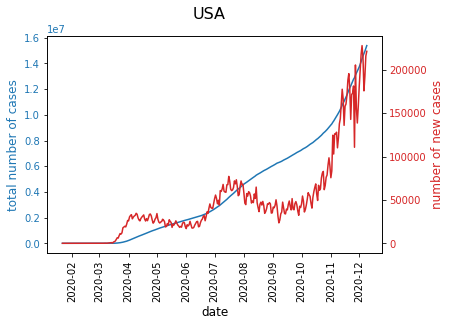

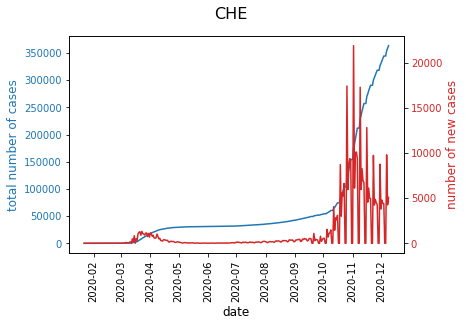

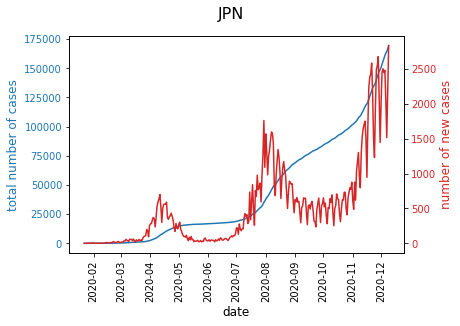

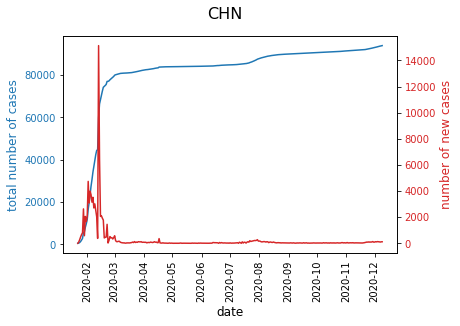

In [16]:
# first overview
for country,df in dfs.items():  
    fig,ax1 = plt.subplots()
    ax1.plot(df.index, df["confirmed"])
    ax1.set_xlabel("date", size=12)
    ax1.tick_params(labelrotation=90, axis="x")
    color = "tab:blue"
    ax1.set_ylabel("total number of cases", color=color, size=12)
    ax1.tick_params(axis="y", labelcolor=color)

    # add that country to the databases
    df_confirmed[country] = df["new_confirmed"] 
    df_total[country] = df["confirmed"]

    ax2 = ax1.twinx()
    color="tab:red"
    ax2.plot(df.index, df["new_confirmed"], color=color)
    ax2.set_ylabel("number of new cases", color=color, size=12)
    ax2.tick_params(axis="y", labelcolor=color)
    fig.suptitle(country, size=16)

    #fig.tight_layout()  
    plt.show()

### Per month

The boxplots below show (potentially) the month(s) where these countries experienced a jump or a big change in the number of new cases. For example, Switzerland experienced some very fast increase in cases in October and November which caused the boxplots to be so wide and with even outliers.

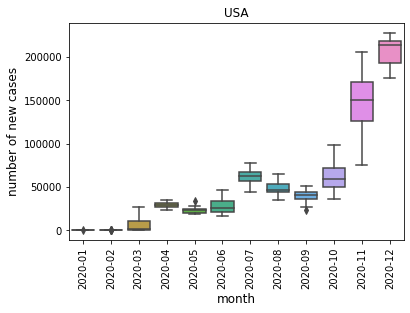

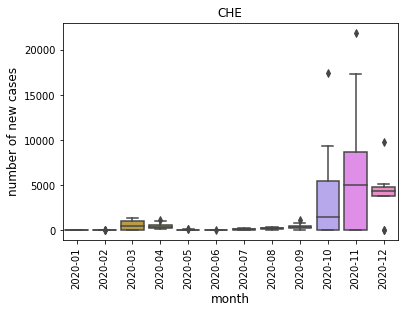

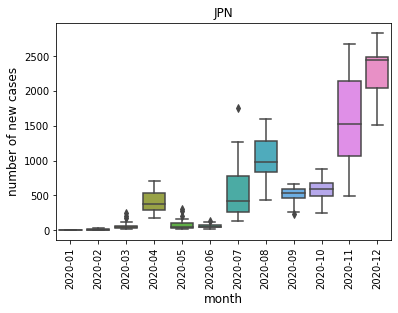

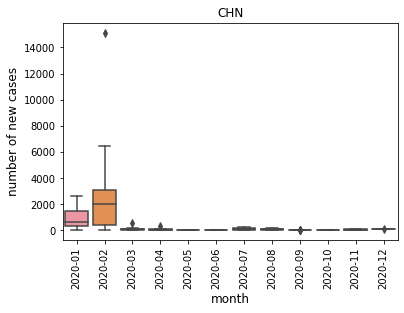

In [17]:
for country,df in dfs.items():
    df["month"] = df["date"].dt.to_period("M")
    plt.figure()
    sns.boxplot(data=df, x="month", y="new_confirmed")
    plt.xticks(rotation=90)
    plt.xlabel("month", size=12)
    plt.ylabel("number of new cases", size=12)
    plt.title(country)
    plt.show()

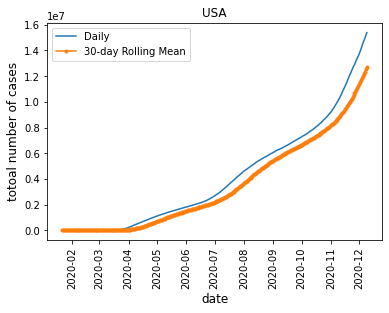

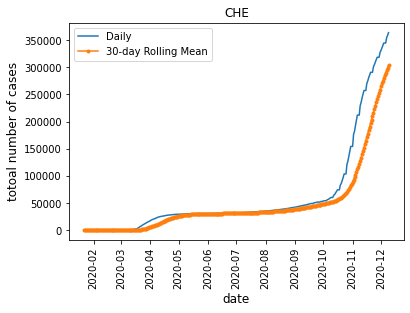

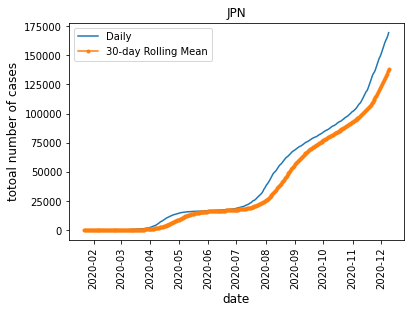

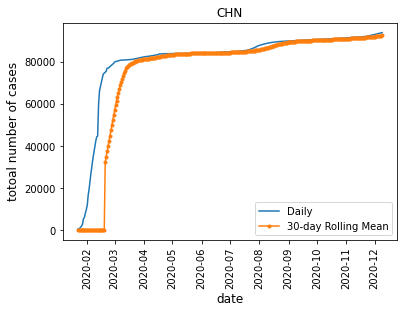

In [18]:
# rolling for cumulative => solution for the problem of late registration of data or non-granularity

for country,df in dfs.items():
    df_30day_rolling = df["confirmed"].rolling(30).mean().fillna(0)
    plt.figure()
    plt.plot(df.date, df["confirmed"], label="Daily")
    plt.plot(df.date, df_30day_rolling, marker=".", label="30-day Rolling Mean")
    plt.xticks(rotation=90)
    plt.xlabel("date", size=12)
    plt.ylabel("totoal number of cases", size=12)
    plt.title(country)
    plt.legend()
    plt.show()

### Per period

In [19]:

mid_period = ("2020-06-12", "2020-10-12")  # arbitrarily chosen, subject to change             
first_period = (start_date, mid_period[0]) # beginning of pandemic
last_period = (mid_period[1], arrow.get(end_date)) # most recent 

In [20]:
test = dfs["CHE"]
test[test.index > mid_period[0]]

,confirmed,date,deaths,recovered,ts_in_secs,new_confirmed,month
date,,,,,,,
2020-06-13 00:00:00+00:00,31094,2020-06-13,1938,28800,1592006400000000000,31.0,2020-06
2020-06-14 00:00:00+00:00,31117,2020-06-14,1938,28800,1592092800000000000,23.0,2020-06
2020-06-15 00:00:00+00:00,31131,2020-06-15,1939,28900,1592179200000000000,14.0,2020-06
2020-06-16 00:00:00+00:00,31154,2020-06-16,1954,28900,1592265600000000000,23.0,2020-06
2020-06-17 00:00:00+00:00,31187,2020-06-17,1956,28900,1592352000000000000,33.0,2020-06
...,...,...,...,...,...,...,...
2020-12-05 00:00:00+00:00,344497,2020-12-05,5324,260600,1607126400000000000,0.0,2020-12
2020-12-06 00:00:00+00:00,344497,2020-12-06,5349,260600,1607212800000000000,0.0,2020-12
2020-12-07 00:00:00+00:00,354306,2020-12-07,5495,279900,1607299200000000000,9809.0,2020-12


## Correlation study New Cases

In [25]:
df_confirmed.head()

,USA,CHE,JPN,CHN
date,,,,
2020-01-22 00:00:00+00:00,0.0,0.0,0.0,0.0
2020-01-23 00:00:00+00:00,0.0,0.0,0.0,95.0
2020-01-24 00:00:00+00:00,1.0,0.0,0.0,277.0
2020-01-25 00:00:00+00:00,0.0,0.0,0.0,486.0
2020-01-26 00:00:00+00:00,3.0,0.0,2.0,669.0


Normalize data

In [26]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_confirmed.values)
df_confirmed_scaled = pd.DataFrame(x_scaled)
df_confirmed_scaled = df_confirmed_scaled.rename(columns={
    0:countries_of_interest[0],
    1:countries_of_interest[1],
    2:countries_of_interest[2],
    3:countries_of_interest[3]
})
df_confirmed_scaled['Date'] = df_confirmed.index
df_confirmed_scaled = df_confirmed_scaled.set_index('Date')
df_confirmed_scaled.head()

,USA,CHE,JPN,CHN
Date,,,,
2020-01-22 00:00:00+00:00,0.000000,0.0,0.000000,0.000066
2020-01-23 00:00:00+00:00,0.000000,0.0,0.000000,0.006342
2020-01-24 00:00:00+00:00,0.000004,0.0,0.000000,0.018366
2020-01-25 00:00:00+00:00,0.000000,0.0,0.000000,0.032173
2020-01-26 00:00:00+00:00,0.000013,0.0,0.000705,0.044262


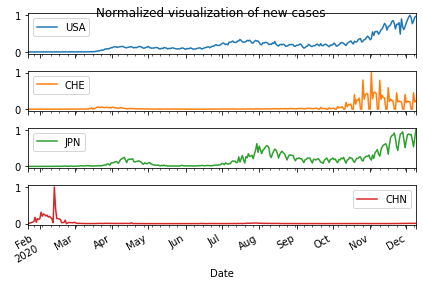

In [27]:
df_confirmed_scaled.plot(subplots=True, title='Normalized visualization of new cases')
plt.tight_layout()
plt.show()

### Correlation matrix of new cases among different countries

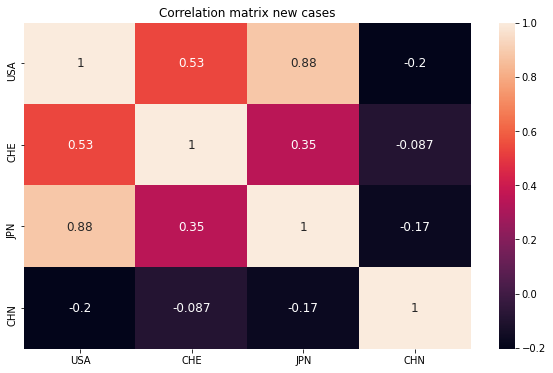

In [28]:
corr = df_confirmed_scaled.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map = plt.gcf()
heat_map.set_size_inches(10,6)
plt.title('Correlation matrix new cases')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## Correlation study Total Cases

In [29]:
df_total.head()

,USA,CHE,JPN,CHN
date,,,,
2020-01-22 00:00:00+00:00,1,0,2,548
2020-01-23 00:00:00+00:00,1,0,2,643
2020-01-24 00:00:00+00:00,2,0,2,920
2020-01-25 00:00:00+00:00,2,0,2,1406
2020-01-26 00:00:00+00:00,5,0,4,2075


Normalize data

In [30]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_total.values)
df_total_scaled = pd.DataFrame(x_scaled)
df_total_scaled = df_total_scaled.rename(columns={
    0:countries_of_interest[0],
    1:countries_of_interest[1],
    2:countries_of_interest[2],
    3:countries_of_interest[3]
})
df_total_scaled['Date'] = df_total.index
df_total_scaled = df_total_scaled.set_index('Date')
df_total_scaled.head()

,USA,CHE,JPN,CHN
Date,,,,
2020-01-22 00:00:00+00:00,0.000000e+00,0.0,0.000000,0.000000
2020-01-23 00:00:00+00:00,0.000000e+00,0.0,0.000000,0.001018
2020-01-24 00:00:00+00:00,6.499178e-08,0.0,0.000000,0.003985
2020-01-25 00:00:00+00:00,6.499178e-08,0.0,0.000000,0.009191
2020-01-26 00:00:00+00:00,2.599671e-07,0.0,0.000012,0.016358


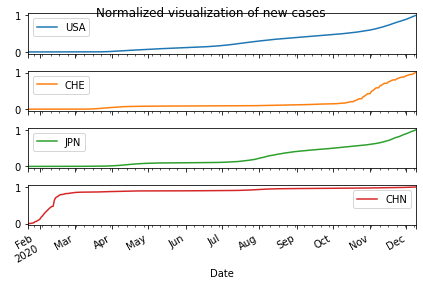

In [31]:
df_total_scaled.plot(subplots=True, title='Normalized visualization of new cases')
plt.tight_layout()
plt.show()

### Correlation matrix of new cases among different countries

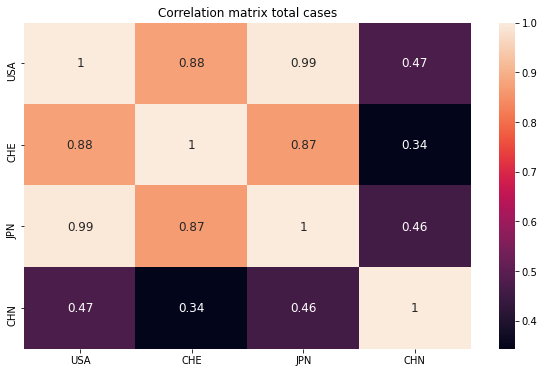

In [32]:
corr = df_total_scaled.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map = plt.gcf()
heat_map.set_size_inches(10,6)
plt.title('Correlation matrix total cases')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [33]:
for country,df in dfs.items():
  # ...
  ...

In [ ]:
# China vs Japan
# ...


# US vs CH
# ...